# Pfand multi class classification

## Libraries

In [ ]:
!pip install scikeras
# !pip install keras-tuner -q
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from tensorflow.keras import layers, Sequential
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import normalize
from random import randint
from itertools import product
from sklearn.cluster import KMeans
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, KFold
import seaborn as sns
import random
from PIL import Image
import cv2
import os
import shutil
from IPython.display import clear_output
import ast 

from google.colab import drive
import glob
from scikeras.wrappers import KerasClassifier






Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
print(tf.__version__)

2.9.2


## Mounting Google Drive

In [ ]:
# Mounting drive
drive.mount('/content/drive')
# Viewing the data in the folder present from the drive
!ls "/content/drive/My Drive/PFAND_CLASSIFIER"

# copying preprocessed data from Google drive
!cp -r '/content/drive/My Drive/PFAND_CLASSIFIER/data_pfand' data 

Mounted at /content/drive
data_pfand			       OLDpfand_clf.ipynb
dataset_preprocessing_Pfand_clf.ipynb  pfand_clf.ipynb
final_model			       randomized_search_results.xlsx
github_shell_pfand_clf.ipynb	       README.md
graphics			       utils.py
model.h5


## Reading dataset

In [ ]:
def readSamplesPathsAndLabels(src_dir):
    """ Reads pathfiles of each image sample and saves their labels with respect to the class folder 
        where the sample was put
    ---
    args:
        src_dir:    path to the directtory containing class folders
    """
    categories = os.listdir(src_dir)
    samples_pathfiles = []
    labels = []


    for label in categories:
        new_pathfiles = os.listdir(f'{src_dir}/{label}')
        samples_pathfiles += new_pathfiles

        new_labels = [label for i in range(len(new_pathfiles))]
        labels += new_labels

    return samples_pathfiles, labels


In [ ]:
image_names, y = readSamplesPathsAndLabels(src_dir="./data/")

image_size = (200, 200)

X = []
for image_name, label in zip(image_names, y):
    img = cv2.imread(f"./data/{label}/{image_name}")
    # flip channels needed because cv2.imread reads BGR colors and matplotlib used for visualisation uses RGB
    img = np.flip(img, axis=-1)
    if img.shape != image_size:
        img = cv2.resize(img, image_size)
    X.append(img)
X = np.array(X)
y = np.array(y)

In [ ]:
img_shape = X[0].shape
img_shape

(200, 200, 3)

### Samples visualisation

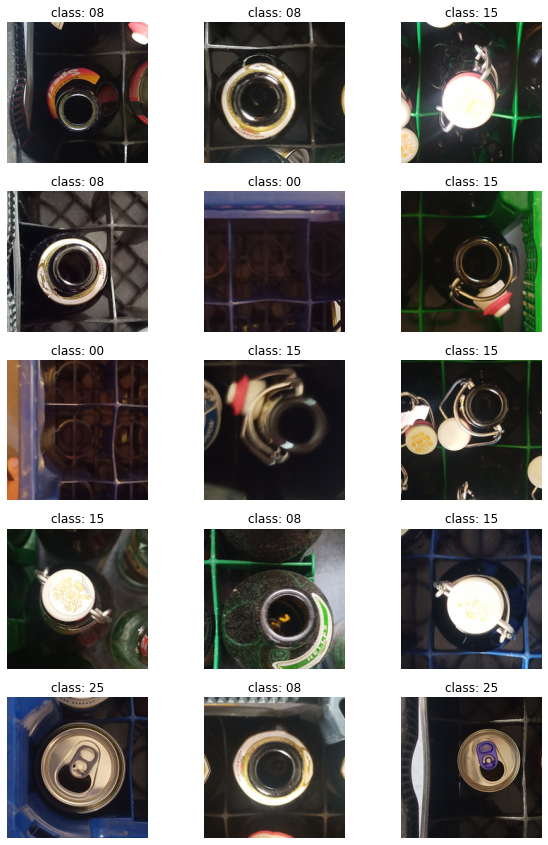

In [ ]:
plt.figure(figsize=(10, 15))
for i in range(15):
    random_id = random.randint(0,len(y))
    img = X[random_id]
    label = y[random_id]
    ax = plt.subplot(5, 3, i + 1)
    ax.title.set_text(f"class: {label}")
    plt.imshow(img)
    plt.axis("off")
plt.show()

## One hot encoding labels

In [ ]:
def ohEncodeLabels(y, oh_dict={"00": [1, 0, 0, 0],
                               "08": [0, 1, 0, 0],
                               "15": [0, 0, 1, 0],
                               "25": [0, 0, 0, 1]}):
    """ Function performs One-Hot encoding on labels array
    ---
    args:
        y:          array of labels to be one-hot encoded
        oh_dict:    Default:{"00": [1, 0, 0, 0],
                             "08": [0, 1, 0, 0],
                             "15": [0, 0, 1, 0],
                             "25": [0, 0, 0, 1]}, a dictionary used for a one-hot encoding
    returns:
        y_oh:   array of one-hot encoded labels 
    """
    
    y_oh = [oh_dict[label] for label in y]

    return np.array(y_oh)

In [ ]:
y_oh = ohEncodeLabels(y, )

## Train-Test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_oh, test_size=0.2, shuffle=True)
print(f"train set size: {len(y_train)}")
print(f"test set size: {len(y_test)}")

train set size: 548
test set size: 137


## Data Augmentation visualisation

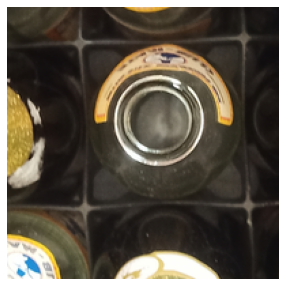

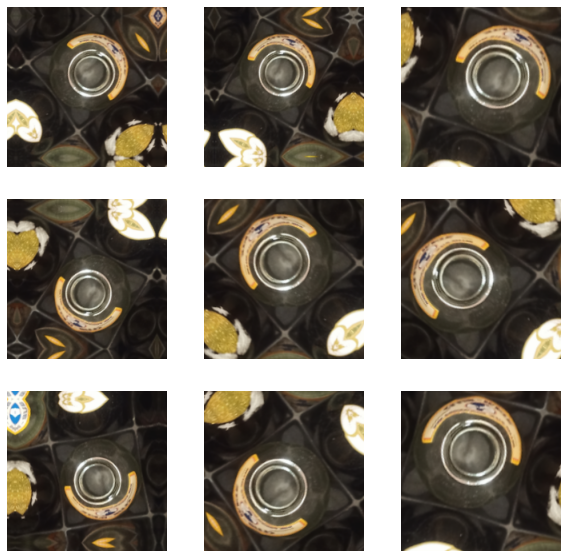

Model: "data_augmentation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (200, 200, 3)             0         
                                                                 
 random_rotation (RandomRota  (200, 200, 3)            0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (200, 200, 3)             0         
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [ ]:
data_augmentation_test = keras.Sequential(
    [
     layers.RandomFlip(),
     layers.RandomRotation(1),
     layers.RandomZoom(0.2),
     ], name='data_augmentation')


plt.figure(figsize=(5, 5))
# random_image = tf.convert_to_tensor(random.choice(X_train))
random_image = random.choice(X_train)

plt.imshow(random_image)
plt.axis("off")
plt.show()

plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = np.array(data_augmentation_test(random_image), dtype="int")
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image)
    plt.axis("off")
plt.show()

data_augmentation_test.summary()


## Build Model functions

In [ ]:
def buildCNNsubmodel(filters=[32],
                     activations=['relu'],
                     kernel_sizes=[3],
                     dropouts=None
             ):
    """ Function builds a middle part of CNN including all the Convolutional, maxPooling and Dropout layers
    ---
    args:
        filters:            list of filters numbers for each convolutional layer -> list
        kernel_sizes:       list of kernel sizes for each convolutional layer -> list
        activations:        list of activation functions for each convolutional layer -> list
        dropouts:           a value of dropout for all layers 
                            (if None then there is no dropout layer for the convolution) -> list
    ---
    returns:
        submodel:           a middle submodel of the CNN
    """
    assert len(filters) == len(kernel_sizes)
    assert len(activations) == len(filters)

    nb_of_conv_layers = len(filters)

    if dropouts == None:
        dropouts = [0 for i in range(nb_of_conv_layers)]
    else:
        dropouts = [dropouts for i in range(nb_of_conv_layers)]

    submodel = Sequential(name='CNN')

    for i in range(nb_of_conv_layers):
        submodel.add(layers.Conv2D(filters[i], 
                                    kernel_size=kernel_sizes[i], 
                                    padding="same", 
                                    activation=activations[i]))
        submodel.add(layers.MaxPool2D(pool_size=2))
        if dropouts[i] != 0:
            submodel.add(layers.Dropout(dropouts[i]))

    # flatten the output of submodel
    submodel.add(layers.Flatten())

    return submodel

def buildModel(img_shape,
               output_shape,
               filters=[32],
               activation='relu',
               dropouts=None,
               ):
    """ Function builds a whole CNN model
    ---
    args:
        img_shape:      shape of an input image sample
        output_shape:   number of classes 
        filters:        list of filters numbers for each convolutional layer
        activation:     activation function for convolutional layers
        dropouts:        a value of dropout for all layers 
                            (if None then there is no dropout layer for the convolution) -> list
    ---
    returns:
        model:      already build and compiled model with data augmentation, rescaling to 0-1 range, 
                    Input and output layers, compilation parameters:
                        - optimizer='adam'
                        - loss='binary_crossentropy', 
                        - metrics=['accuracy']
    """
    layers_nb = len(filters)
    model = Sequential()
    model.add(keras.Input(shape=img_shape))
    # data augmentation
    data_augmentation = keras.Sequential(
        [
            layers.RandomFlip(),
            layers.RandomRotation(1),
            layers.RandomZoom(0.2),
         ], name='data_augmentation') 
    model.add(data_augmentation)  
    # Rescaling images to 0-1 range
    model.add(layers.Rescaling(1./255))
    # Conv layers
    CNN = buildCNNsubmodel(filters=filters,
                           activations=[activation for i in range(layers_nb)],
                           kernel_sizes=[3 for i in range(layers_nb)],
                           dropouts=dropouts)
    model.add(CNN)
    # output layer
    model.add(layers.Dense(output_shape, activation="sigmoid"))

    model.compile(optimizer='adam', 
                  loss='binary_crossentropy', 
                  metrics=['accuracy']
                  )

    return model

## Random Search

In [ ]:
filters =[
    [32, 64, 128, 256, 256],
    [32, 64, 128, 256],
    [32, 64, 128, 256, 512],
    [64, 128, 256, 512],
    [128, 256, 256],
    [128, 256, 512]
]
activations = ['relu', 'selu']
batch_sizes = [16, 32, 64, 128]
dropouts = [None, 0.2, 0.5]

nb_combinations = len(list(product(filters, activations, batch_sizes, dropouts)))

params = dict(
	model__filters=filters,
    model__activation=activations,
    batch_size=batch_sizes,
    model__dropouts=dropouts
)

print(f"number of combinations: {nb_combinations}")
params

number of combinations: 144


{'model__filters': [[32, 64, 128, 256, 256],
  [32, 64, 128, 256],
  [32, 64, 128, 256, 512],
  [64, 128, 256, 512],
  [128, 256, 256],
  [128, 256, 512]],
 'model__activation': ['relu', 'selu'],
 'batch_size': [16, 32, 64, 128],
 'model__dropouts': [None, 0.2, 0.5]}

In [ ]:
# wrap model into a scikit-learn compatible classifier
search_model = KerasClassifier(model=buildModel,
                               verbose=0,
                               img_shape=img_shape,
                               output_shape=4,
                            #    data_augmentation=data_augmentation,
                               )

random_search = RandomizedSearchCV(estimator=search_model,
                                   param_distributions=params,
                                   n_iter=40,
                                   n_jobs=1,
                                   scoring="accuracy",
                                   error_score='raise',
                                   return_train_score=True,
                                   verbose=0,
                                   cv=3
                                   )

callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',
                                           verbose=0,
                                           patience=3,
                                        )]


search_results = random_search.fit(X_train,
                                   y_train,
                                   epochs=40,
                                   callbacks=callbacks,
                                   )

clear_output()

# summarize grid search information
best_score = search_results.best_score_
best_params = search_results.best_params_
print(f"best score: {best_score:.2f}\nbest parameters: {best_params}")

best score: 0.96
best parameters: {'model__filters': [32, 64, 128, 256, 512], 'model__dropouts': 0.2, 'model__activation': 'relu', 'batch_size': 32}


In [ ]:
# ## Prepare search results table
# search_results_table = pd.DataFrame(search_results.cv_results_)
# # adding a column for filters as strings so that they can be visualised in catplot
# search_results_table["param_model__filters_str"] = search_results_table["param_model__filters"].astype(str)
# search_results_table["param_model__dropouts_str"] = search_results_table["param_model__dropouts"].astype(str)

# ## save results on google drive
# search_results_table.to_excel('/content/drive/My Drive/PFAND_CLASSIFIER/randomized_search_results.xlsx')

search_results_table = pd.read_excel('/content/drive/My Drive/PFAND_CLASSIFIER/randomized_search_results.xlsx')
search_results_table

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__filters,param_model__dropouts,param_model__activation,param_batch_size,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score,param_model__filters_str,param_model__dropouts_str
0,0.0,83.251008,0.199124,0.283328,0.001142,"[128, 256, 256]",0.2,selu,32.0,"{'model__filters': [128, 256, 256], 'model__dr...",...,0.711684,0.031286,32.0,0.824658,0.734247,0.745902,0.768269,0.040156,"[128, 256, 256]",0.2
1,1.0,19.502578,2.991282,0.201430,0.031812,"[32, 64, 128, 256]",0.5,relu,32.0,"{'model__filters': [32, 64, 128, 256], 'model_...",...,0.724474,0.025917,29.0,0.780822,0.830137,0.713115,0.774691,0.047970,"[32, 64, 128, 256]",0.5
2,2.0,83.117163,0.179757,0.321083,0.052200,"[128, 256, 256]",0.5,selu,32.0,"{'model__filters': [128, 256, 256], 'model__dr...",...,0.633399,0.127610,34.0,0.791781,0.520548,0.740437,0.684255,0.117641,"[128, 256, 256]",0.5
3,3.0,69.495278,18.971699,0.280304,0.008217,"[128, 256, 256]",NaN,selu,32.0,"{'model__filters': [128, 256, 256], 'model__dr...",...,0.782772,0.029342,21.0,0.832877,0.857534,0.814208,0.834873,0.017744,"[128, 256, 256]",None
4,4.0,18.849420,1.945845,0.214352,0.018765,"[32, 64, 128, 256]",0.5,relu,16.0,"{'model__filters': [32, 64, 128, 256], 'model_...",...,0.752037,0.108790,25.0,0.868493,0.660274,0.923497,0.817421,0.113366,"[32, 64, 128, 256]",0.5
5,5.0,41.999805,0.005980,0.281521,0.029107,"[64, 128, 256, 512]",NaN,selu,16.0,"{'model__filters': [64, 128, 256, 512], 'model...",...,0.852159,0.013755,18.0,0.923288,0.857534,0.879781,0.886868,0.027307,"[64, 128, 256, 512]",None
6,6.0,16.989609,3.250543,0.183272,0.010282,"[32, 64, 128, 256, 512]",NaN,relu,64.0,"{'model__filters': [32, 64, 128, 256, 512], 'm...",...,0.937899,0.023126,6.0,0.975342,0.980822,0.972678,0.976281,0.003390,"[32, 64, 128, 256, 512]",None
7,7.0,19.990357,1.220550,0.215941,0.030866,"[32, 64, 128, 256, 512]",0.2,relu,16.0,"{'model__filters': [32, 64, 128, 256, 512], 'm...",...,0.947097,0.016849,2.0,0.989041,0.972603,0.989071,0.983572,0.007756,"[32, 64, 128, 256, 512]",0.2
8,8.0,19.967367,2.777854,0.181774,0.009553,"[32, 64, 128, 256, 256]",0.2,relu,32.0,"{'model__filters': [32, 64, 128, 256, 256], 'm...",...,0.943444,0.018541,3.0,0.991781,0.989041,0.972678,0.984500,0.008434,"[32, 64, 128, 256, 256]",0.2
9,9.0,17.032604,3.263196,0.168398,0.002757,"[32, 64, 128, 256]",0.5,selu,64.0,"{'model__filters': [32, 64, 128, 256], 'model_...",...,0.633199,0.060426,35.0,0.736986,0.589041,0.612022,0.646016,0.065006,"[32, 64, 128, 256]",0.5


In [ ]:
def visualiseSearchResults(search_results, params):
    """ Function displays catplots showing accuracies obtained for different parameters
    ---
    args:
        search_results:     pd.DataFrame with search results
        params:             dictionary of parameters used in RandomisedSearchCV / GridSearchCV
    """
    for i, param in enumerate(params.keys()):
        if param == 'model__filters' or param == 'model__dropouts':
            param = param +'_str'
        

        plt.figure(i)
        sns.catplot(x='param_' + param, y='mean_test_score', data=search_results, s=8, height=4, aspect=3)
        plt.ylabel('mean accuracy')
        plt.grid()
        plt.show()

<Figure size 432x288 with 0 Axes>

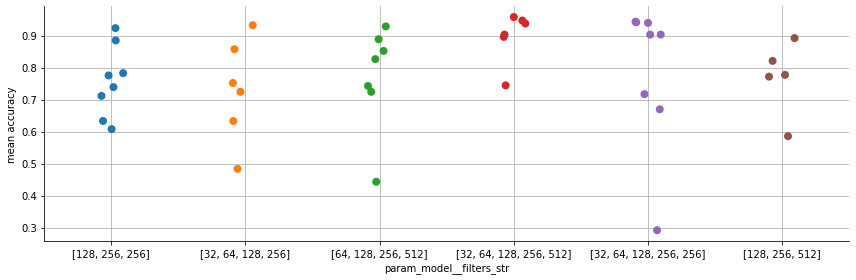

<Figure size 432x288 with 0 Axes>

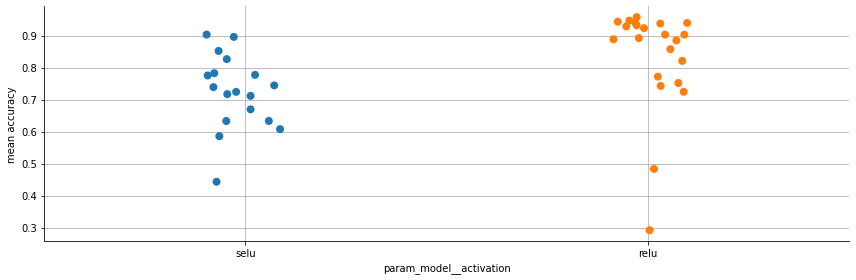

<Figure size 432x288 with 0 Axes>

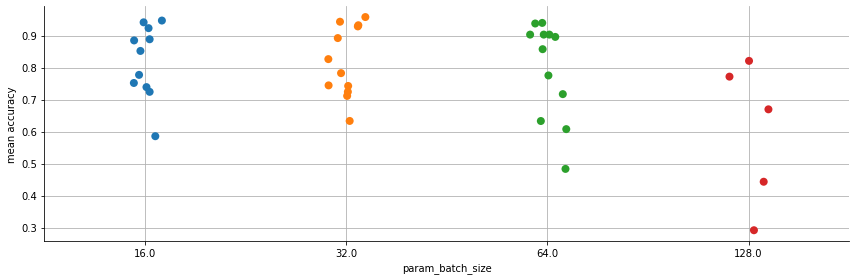

<Figure size 432x288 with 0 Axes>

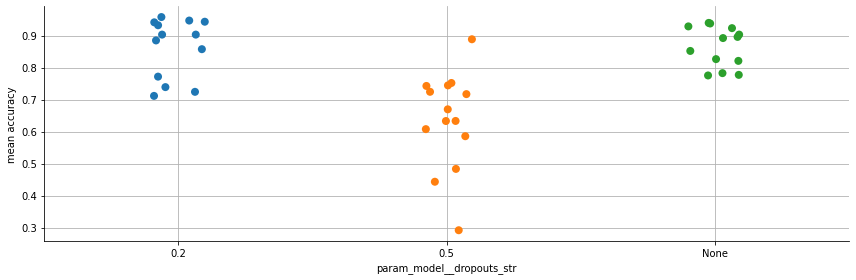

In [ ]:
visualiseSearchResults(search_results_table, params)

## Final Model

In [ ]:
# read best_params, literal_eval converts string to dict
best_params = ast.literal_eval(search_results_table.loc[search_results_table.mean_test_score.idxmax()].params)

cnn_clf = buildModel(img_shape=img_shape,
                        output_shape=4,
                        filters=best_params['model__filters'],
                        activation=best_params['model__activation'],
                        dropouts=best_params['model__dropouts']
                     )
cnn_clf.summary()
# summary of CNN submodel
cnn_clf.layers[2].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequenti  (None, 200, 200, 3)      0         
 al)                                                             
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 CNN (Sequential)            (None, 18432)             1568576   
                                                                 
 dense (Dense)               (None, 4)                 73732     
                                                                 
Total params: 1,642,308
Trainable params: 1,642,308
Non-trainable params: 0
_________________________________________________________________
Model: "CNN"
_________________________________________________________________
 Layer (type)                Outp

In [ ]:
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',
                                           verbose=0,
                                           patience=5,
                                           restore_best_weights=True
                                        )]
                                        
history = cnn_clf.fit(X_train,
                      y_train,
                      epochs=60,
                      batch_size=best_params['batch_size'],
                      validation_split=0.2,
                      callbacks=callbacks)

Epoch 1/60
14/14 [==============================] - 12s 179ms/step - loss: 0.5905 - accuracy: 0.3973 - val_loss: 0.5384 - val_accuracy: 0.3273
Epoch 2/60
14/14 [==============================] - 1s 86ms/step - loss: 0.5335 - accuracy: 0.4087 - val_loss: 0.5291 - val_accuracy: 0.3273
Epoch 3/60
14/14 [==============================] - 1s 79ms/step - loss: 0.5045 - accuracy: 0.4064 - val_loss: 0.4891 - val_accuracy: 0.3364
Epoch 4/60
14/14 [==============================] - 1s 84ms/step - loss: 0.4488 - accuracy: 0.4703 - val_loss: 0.4265 - val_accuracy: 0.5455
Epoch 5/60
14/14 [==============================] - 1s 85ms/step - loss: 0.4135 - accuracy: 0.5662 - val_loss: 0.3827 - val_accuracy: 0.6636
Epoch 6/60
14/14 [==============================] - 1s 85ms/step - loss: 0.3719 - accuracy: 0.6667 - val_loss: 0.3275 - val_accuracy: 0.7182
Epoch 7/60
14/14 [==============================] - 1s 85ms/step - loss: 0.3234 - accuracy: 0.7146 - val_loss: 0.3300 - val_accuracy: 0.6909
Epoch 8/60


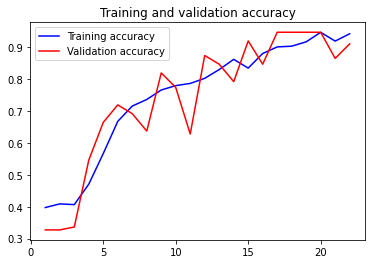

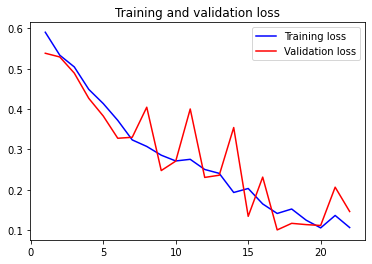

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "b", label="Training accuracy")
plt.plot(epochs, val_accuracy, "r", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "b", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

## test evaluation

In [ ]:
test_loss, test_acc = cnn_clf.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.3f}")

5/5 [==============================] - 0s 74ms/step - loss: 0.1010 - accuracy: 0.9270
Test accuracy: 0.927


In [ ]:
predicts_oh = cnn_clf.predict(X_test)
# One_hot decoding
oh_to_true_label = {0: 0,
                    1: 8,
                    2: 15,
                    3: 25}
# predictions cat - category, after one hot decoding
y_pred_cat = [oh_to_true_label[np.argmax(predict_oh)] for predict_oh in predicts_oh]
# ground_truths
y_test_cat = [oh_to_true_label[np.argmax(label)] for label in y_test]

5/5 [==============================] - 0s 19ms/step


In [ ]:
def makeConfusionMatrix(y_test, y_pred, classes={0: 0, 8: 1, 15: 2, 25: 3}):
    """ Function creates a confucion matrix showing counts of well predicted and mispredicted samples from test dataset
    ---
    args:
        y_test:     array of ground truths in test dataset
        y_pred:     array of model predictions to test dataset
        classes:    default={0: 0, 8: 1, 15: 2, 25: 3}, dictionary of classes name for each one-hot code
    """

    conf_matrix = np.zeros((len(classes), len(classes)))
    # rows - ground_truth/ label
    # columns - prediction
    for label, pred in zip(y_test, y_pred):
        row = classes[label]
        column = classes[pred]
        conf_matrix[row, column] +=1
    
    df = pd.DataFrame(conf_matrix, columns=classes.keys(), index=classes.keys())
    return df

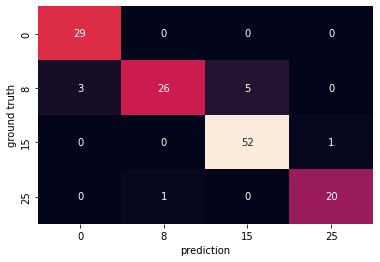

In [ ]:
conf_matrix = makeConfusionMatrix(y_test_cat, y_pred_cat)

plt.figure()
sns.heatmap(conf_matrix, annot=True, cbar=False)
plt.ylabel("ground truth")
plt.xlabel("prediction")
plt.show()

## Inspecting mispredicted samples

In [ ]:
def displayMispredictions(X, y, y_pred):
    """ Function displays images of samples that were mispredicted by the model
    ---
    args:
        X:      array with images
        y:      array with ground truth labels
        y_pred: array with model predictions
    """
    mispredictions_ids = []
    for i in range(len(y)):
        if y[i] != y_pred[i]:
            mispredictions_ids.append(i)
    
    nb_of_mispredictions = len(mispredictions_ids)
    plt.figure(figsize=(10, 3*nb_of_mispredictions))
    for i in range(nb_of_mispredictions):
        ax = plt.subplot(nb_of_mispredictions, 1, i + 1)
        ax.set_title(f"prediction: {y_pred[mispredictions_ids[i]]}, ground truth: {y[mispredictions_ids[i]]}")
        plt.imshow(X[mispredictions_ids[i]])
        plt.axis("off")

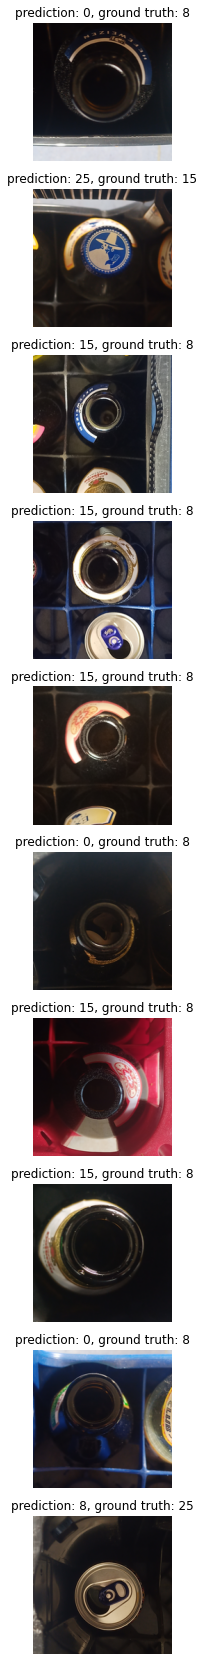

In [ ]:
displayMispredictions(X_test, y_test_cat, y_pred_cat)

## Save final model

### Full tensorflow model

In [ ]:
cnn_clf.save("/content/drive/My Drive/PFAND_CLASSIFIER/model.h5")

In [ ]:
# load model
cnn_clf = keras.models.load_model("/content/drive/My Drive/PFAND_CLASSIFIER/model.h5")
cnn_clf.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequenti  (None, 200, 200, 3)      0         
 al)                                                             
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 CNN (Sequential)            (None, 18432)             1568576   
                                                                 
 dense (Dense)               (None, 4)                 73732     
                                                                 
Total params: 1,642,308
Trainable params: 1,642,308
Non-trainable params: 0
_________________________________________________________________


## Tensorflow Lite model

In [25]:
# convert keras model to tfLite

converter = tf.lite.TFLiteConverter.from_keras_model(cnn_clf)
tflite_model = converter.convert()

In [30]:
# save tf lite model
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

with open("/content/drive/My Drive/PFAND_CLASSIFIER/model.tflite", 'wb') as f:
    f.write(tflite_model)

In [26]:
!pip install tflite_runtime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 15.7 MB/s 


In [32]:
import tflite_runtime.interpreter as tflite

!cp -r '/content/drive/My Drive/PFAND_CLASSIFIER/model.tflite' model.tflite 

model = tflite.Interpreter("model.tflite")
model

In [34]:
model.allocate_tensors()

input_details = model.get_input_details()
input_details

[{'name': 'serving_default_input_1:0',
  'index': 0,
  'shape': array([  1, 200, 200,   3], dtype=int32),
  'shape_signature': array([ -1, 200, 200,   3], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

**TensorflowLite takes FLOAT32 input!!!**

In [36]:
output_details = model.get_output_details()
output_details

[{'name': 'StatefulPartitionedCall:0',
  'index': 26,
  'shape': array([1, 4], dtype=int32),
  'shape_signature': array([-1,  4], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [69]:
# create function to make a prediction with TFLite model

def predictLite(image):
    """Makes a prediction on a sample with a tensorflow Lite converted model
    ---
    args:
        img:        input sample
    returns:
        pred:       prediction class probabilities
    """
    model.set_tensor(input_details[0]['index'], image.reshape((1, 200, 200, 3)))
    model.invoke()
    pred = model.get_tensor(output_details[0]['index']).reshape((4,))

    return pred

In [72]:
# Convert input to FLOAT32!
pred = predictLite(X_test[1].astype(np.float32))
np.argmax(pred)

1

In [71]:
np.argmax(y_test[1])

1